## Introduction:

Competition link ==> https://www.kaggle.com/c/pkdd-15-predict-taxi-service-trajectory-i

### Problem statement:
1. In most cases, taxi drivers operating with an electronic dispatch system do not indicate the final destination of their current ride.
2. Since taxis using electronic dispatch systems do not usually enter their drop off location, it is extremely difficult for dispatchers to know which taxi to contact. 

### Solution:
- Predict the final destination of a taxi while it is in service based on (initial) partial trajectories. 
- The output of such a framework must be the final trip's destination (WGS84 coordinates)

In [1]:
## data manipulation
import numpy as np
import pandas as pd

## reading the data 
import json
import zipfile
import csv

## plotting .. 
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

## clustering 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

## Feature Selection 
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


## warnings
import warnings
warnings.filterwarnings("ignore")

## Reading the data:

In [2]:
zf = zipfile.ZipFile('train.csv.zip')
df = pd.read_csv(zf.open('train.csv'), converters={'POLYLINE': lambda x: json.loads(x)[-1:]})

In [32]:
df.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.630838, 41.154489]]"
1,1372637303620000596,B,NaN,7,20000596,1372637303,A,False,"[[-8.66574, 41.170671]]"
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.61597, 41.14053]]"
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.607996, 41.142915]]"
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.687268, 41.178087]]"


I think by using load(x) [-1:] we extracted the data of the distination (i.e. long and latitude related to the distination of the trip .. instead of retreiving the whole sequance of longitudes and latitudes .. 

Thus, POLYLINE is now ready to be used as a dependent variable in prediction ..

In [33]:
np.shape(df)

(1710670, 9)

There are about 1M+ records in this file ..

As POLYLINE is the predicted variable .. and as it contains two values [longitude, latitude] .. 
I splitted these values into two seperate columns using R (just for simplicity and for trying different languages) .. 

The R code is stems from this notebook ==> https://www.kaggle.com/benhamner/last-location-benchmark

What I'm gonna do now is to read the splitted POLYLINE from the file and add the new columns to the data frame .. 

In [4]:
polyline = pd.read_csv('last_location_benchmark.csv')
polyline.head()

,TRIP_ID,LATITUDE,LONGITUDE
0,1.372637e+18,41.154489,-8.630838
1,1.372637e+18,41.170671,-8.665740
2,1.372637e+18,41.140530,-8.615970
3,1.372637e+18,41.142915,-8.607996
4,1.372637e+18,41.178087,-8.687268


In [5]:
polyline['LATITUDE'].head()

0    41.154489
1    41.170671
2    41.140530
3    41.142915
4    41.178087
Name: LATITUDE, dtype: float64

In [7]:
df['LATITUDE'] = polyline['LATITUDE']
df['LONGITUDE'] = polyline['LONGITUDE']
df.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LATITUDE,LONGITUDE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.630838, 41.154489]]",41.154489,-8.630838
1,1372637303620000596,B,NaN,7,20000596,1372637303,A,False,"[[-8.66574, 41.170671]]",41.170671,-8.665740
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.61597, 41.14053]]",41.140530,-8.615970
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.607996, 41.142915]]",41.142915,-8.607996
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.687268, 41.178087]]",41.178087,-8.687268


## splitting the data: 
Before doing any kind of anaylsis .. we have to split the data into training (sometimes calles testing) and validation sets .. 

In [8]:
# ntrain .. 80% of the data as training data
ntrain = (len(df)*80)/100
train_data, test_data = df[:ntrain], df[ntrain+1:]

print("The length of the training set" ,len(train_data))
print("The length of the testing set" ,len(test_data))
print("The length of the data after splitting" ,len(train_data) + len(test_data))

('The length of the training set', 1368536)
('The length of the testing set', 342133)
('The length of the data after splitting', 1710669)


Well .. 

We gonna utilize only the training data of 1.4 million records in our analysis ..

## Data Exploration:
1. Trip_id, origin_call, origin_stand, taxi_id and time_stamp: int 
2. Call_type, dat_type: categotical
3. Missing_data: boolean
4. Polyline: series of [long, lat] represent the trip positions every 15 seconds

This means that the target variable is the last position in the polyline .. 

In [7]:
train_data.isnull().any()

TRIP_ID         False
CALL_TYPE       False
ORIGIN_CALL      True
ORIGIN_STAND     True
TAXI_ID         False
TIMESTAMP       False
DAY_TYPE        False
MISSING_DATA    False
POLYLINE        False
dtype: bool

Only ORIGIN_CALL and ORIGIN_STAND having missing values .. 
 
let's count them ..

In [8]:
train_data.isnull().sum()

TRIP_ID               0
CALL_TYPE             0
ORIGIN_CALL     1074556
ORIGIN_STAND     718938
TAXI_ID               0
TIMESTAMP             0
DAY_TYPE              0
MISSING_DATA          0
POLYLINE              0
dtype: int64

Oh .. 

Huge number of records are missing .. we could not ignore them !

In [9]:
unique_id = pd.Series(train_data['TRIP_ID'].unique())
limit = 1.2e4
unique_id = unique_id.sample(n = limit)
train_data = train_data[train_data.TRIP_ID.isin(unique_id)]
train_data.describe()

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,MISSING_DATA
count,1.200000e+04,2555.000000,5759.000000,12000.000000,1.200000e+04,12000
mean,1.385424e+18,24692.093542,30.112346,20000350.710000,1.385424e+09,0
std,7.393313e+15,19820.636923,17.735036,210.785227,7.393313e+06,0
min,1.372641e+18,2001.000000,1.000000,20000001.000000,1.372641e+09,False
25%,1.379226e+18,6518.000000,15.000000,20000167.000000,1.379226e+09,0
50%,1.385408e+18,19146.000000,27.000000,20000346.000000,1.385408e+09,0
75%,1.391898e+18,41277.000000,47.000000,20000520.000000,1.391898e+09,0
max,1.398382e+18,63882.000000,63.000000,20000904.000000,1.398382e+09,False


This is normal to have replication in taxi_id .. let's check the unique values in both taxi_id and trip_id

In [10]:
len(train_data['TRIP_ID'].unique()), len(train_data['TAXI_ID'].unique())

(12000, 437)

Make sense .. 

To have 437 taxi doing 12000 trip along the year ! 

As the number of the trips equals the count of missing_data column .. this means that this column contains only FALSE values .. which means that ALL the polyline data are there ! .. 

Let's double check .. 

In [11]:
train_data['MISSING_DATA'].unique()

array([False], dtype=object)

YUP :) 

No missing polyline values .. 


### Let's work on Polyline column ..

In [12]:
latlong = np.array([[p[0][1], p[0][0]] for p in df['POLYLINE'] if len(p)>0])

In [13]:
latlong

array([[ 41.154489,  -8.630838],
       [ 41.170671,  -8.66574 ],
       [ 41.14053 ,  -8.61597 ],
       ..., 
       [ 41.158755,  -8.627454],
       [ 41.173524,  -8.587026],
       [ 41.149881,  -8.620893]])

In [14]:
np.shape(latlong)

(1704769, 2)

As mentioned above, the latlong column now represents the latitude and longitude of the final distincation of each trip .. 

Let's cluster to find the most visited places ..

In [15]:
range_n_clusters = [3]

In [16]:
for n_clusters in range_n_clusters:    
    clusterer = KMeans(n_clusters=n_clusters, verbose =1, n_jobs = -1).fit(latlong)
    cluster_labels = clusterer.labels_
    silhouette_avg = silhouette_score(latlong, cluster_labels, sample_size = 10000)
    # The Silhouette Coefficient is calculated using the mean intra-cluster distance and the mean nearest-cluster distance for each sample.

Initialization complete
Initialization complete
Initialization complete
Initialization complete
Iteration  0, inertia 6852.329
Iteration  0, inertia 5951.670
Iteration  0, inertia 5241.570
Iteration  0, inertia 8910.705
Iteration  1, inertia 5212.121
Converged at iteration 1
Iteration  1, inertia 5212.121
Converged at iteration 1
Iteration  1, inertia 8217.702
Iteration  1, inertia 4778.855
Iteration  2, inertia 8182.898
Iteration  2, inertia 4757.567
Iteration  3, inertia 4754.498
Iteration  3, inertia 8169.453
Iteration  4, inertia 4754.005
Converged at iteration 4
Iteration  4, inertia 8167.104
Iteration  5, inertia 8166.059
Iteration  6, inertia 8164.529
Iteration  7, inertia 8164.078
Converged at iteration 7
Initialization complete
Initialization complete
Iteration  0, inertia 6429.042
Initialization complete
Initialization complete
Iteration  0, inertia 5274.252
Iteration  1, inertia 5410.245
Iteration  0, inertia 5207.178
Iteration  0, inertia 7369.318
Iteration  1, inertia 4792

In [17]:
print("For n_clusters = ", n_clusters," The average silhouette_score is : ", silhouette_avg)

('For n_clusters = ', 3, ' The average silhouette_score is : ', 0.46287590332722067)


It seems that the average distance between the 3 clusters is high !.. 

Let's plot heatmap for better visualization .. 

In [18]:
bins = 1000
lat_min, lat_max = 41.04961, 41.24961
lon_min, lon_max = -8.71099, -8.51099

Note that the coordinates of porto are [41.1496100, -8.6109900] .. this means that the above lat_min and max and lon_min and max are chosen randomly just to dominate the coordinates of porto .. 

In [19]:
# process data in chunks to avoid using too much memory
z = np.zeros((bins, bins))

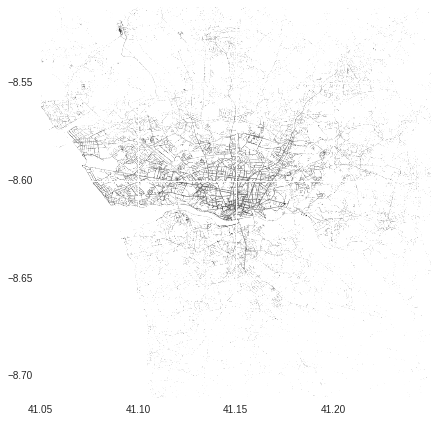

In [20]:
plt.figure(figsize = (11,7))

for chunk in df:
    z += np.histogram2d(*latlong.T, bins=bins, range=[[lat_min, lat_max], [lon_min, lon_max]])[0]
    log_density = np.log(1+z)
    plt.imshow(log_density[::-1,:], extent=[lat_min, lat_max, lon_min, lon_max]) # flip vertically

The heatmap shows that the hottest visited places are those in the middle .. around 41.15 latitude and -8.63 to around -8.58 longitude ..  

## Let's manipulate missing data:

As we already have huge number of missing points .. we could not ignore their effect ! .. 

let's fill them by the mean values .. cause we are dealing with numerical variables .. 

Only ORIGIN_CALL and ORIGIN_STAND have missing values .. 

thus, before filling them with the mean value of the whole column .. 

The point is that it makes sense for those variables to have null values .. i.e. the ORIGIN_STAND is null whenever the CALL_TYPE is any value rather than B .. 

Hence, let's check if there is any relationship between those variables .. or if we can cluster them and fill their cells by the mean of its corresponding cluster !

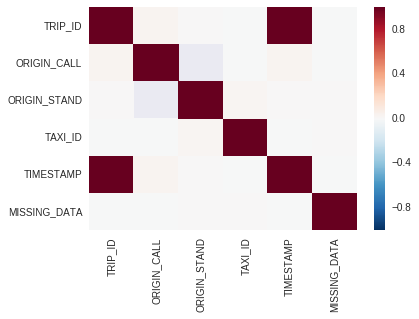

In [21]:
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

In [22]:
np.corrcoef([df.TAXI_ID, df.TIMESTAMP, df.TRIP_ID, df.ORIGIN_CALL, df.ORIGIN_STAND])

array([[ 1.        , -0.00298254, -0.00298254,         nan,         nan],
       [-0.00298254,  1.        ,  1.        ,         nan,         nan],
       [-0.00298254,  1.        ,  1.        ,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan],
       [        nan,         nan,         nan,         nan,         nan]])

The above plot is a heatmap that demonestrates the correlation between the numerical variables .. 

It shows that there is no strong correlation between those variables except (Taxi_ID and TIME_STAMP) that is a Unix Timestamp (in seconds), it identifies the trip’s start .. 

I think this strong correlation is intuitive cause it makes sense for every taxo to have a time for its correponding stip start time .. 

The numerical correlation matrix assures the information extracted from the heatmap .. 

mmmm .. 

Well, let's check if there is a relationship between the ORIGIN_CALL, ORIGIN_STAND and CALL_TYPE .. 

In [65]:
## CALL_TYPE ..
train_data['CALL_TYPE'].value_counts()

B    658157
C    416399
A    293980
Name: CALL_TYPE, dtype: int64

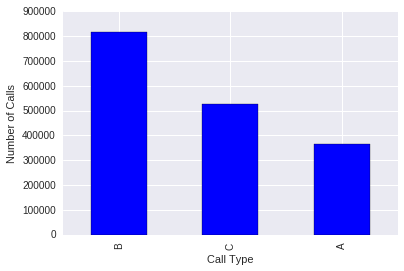

In [66]:
df.CALL_TYPE.value_counts().plot(kind='bar')
plt.xlabel("Call Type")
plt.ylabel("Number of Calls")

There is no huge gap between the number of calls stems from each source .. however, the maximum number of call comes from B ..  that indicates that this trip was demanded directly to a taxi driver on a specific stand ..

In [67]:
train_data['ORIGIN_STAND'].value_counts().head()

15    64560
57    39944
9     28479
33    27802
23    27159
Name: ORIGIN_STAND, dtype: int64

The majority of the calls comes from stand number 15 (ORIGIN_STAND contains an unique identifier for the taxi stand. It identifies the starting point of the trip if CALL_TYPE = ’B’. Otherwise, it assumes a NULL value)



In [68]:
train_data['ORIGIN_CALL'].value_counts().head()

2002     45274
63882     5306
2001      2137
13168     1072
6728       883
Name: ORIGIN_CALL, dtype: int64

The majority of the calls comes from the sourse number 2002 (note that this variable contains an unique identifier for each phone number which was used to demand, at least, one service. It identifies the trip’s customer if CALL_TYPE=’A’. Otherwise, it assumes a NULL value)

### Conclusion:
There has to be an implecit relationship between these three variables .. if CALL_TYPE = 'B' ORIGIN_STAND has to take value .. If it is set to 'A' ORIGIN_CALL has to take value .. else, it is expected to be 'C' which means that the trip is demanded on a random street ..

Let's group the data in both ORIGIN_STAND and ORIGIN_CALL based on CALL_TYPE to be able to impute the missing values with the median (to avoid biasness as the data as +ve skewed) correponding to each CALL_TYPE .. 

In [9]:
stand = train_data.loc[train_data.ORIGIN_STAND.notnull(), :].groupby("CALL_TYPE").agg({"ORIGIN_STAND":{"Median_Stand":np.median}})
stand.values  # as stand now is a data dict

array([[ 27.]])

In [10]:
train_data.groupby(['CALL_TYPE'])['ORIGIN_STAND'].agg('sum')

CALL_TYPE
A         NaN
B    19599671
C         NaN
Name: ORIGIN_STAND, dtype: float64

This assures the info. that the call type B comes only from origin_stand .. 

hence, let's safely replace any NA in origin_stand with the median of that column (i.e. 27)

In [11]:
train_data['ORIGIN_STAND'].fillna(train_data['ORIGIN_STAND'].mean(), inplace = True)

In [12]:
## let's check if it works well .. 
train_data['ORIGIN_STAND'].isnull().any().any()

False

Great .. these is no NAs in ORIGIN_STAND so far .. 

Let's do the same with ORIGIN_CALL .. 

In [13]:
call = train_data.loc[train_data.ORIGIN_CALL.notnull(), :].groupby("CALL_TYPE").agg({"ORIGIN_CALL":{"Median_Call":np.median}})
call.values  # as stand now is a data dict

array([[ 18723.]])

In [14]:
train_data['ORIGIN_CALL'].fillna(train_data['ORIGIN_CALL'].mean(), inplace = True)

In [15]:
## let's check if it works well .. 
train_data['ORIGIN_CALL'].isnull().any().any()

False

It works well (y)

## Checking DAY_TYPE column: 

Let's check day_type column alittle bit colser and test its relationship with other variables ..  

In [34]:
df['DAY_TYPE'].value_counts()

A    1710670
Name: DAY_TYPE, dtype: int64

In [35]:
df['DAY_TYPE'].describe()

count     1710670
unique          1
top             A
freq      1710670
Name: DAY_TYPE, dtype: object

mmmm .. it might be strange for that column to have only A values .. this means that all the calls where in a normal day, workday or weekend .. 

This might be becuase we are only working on a sample data from the available training set .. hence, the rest of the data might contains other values ..  

## Manipulate the char variables:
convert characters of CALL_TYPE and DAY_TYPE to integers to be able to utilize them in upcoming stages .. 

In [16]:
train_data['CALL_TYPE'] = pd.get_dummies(train_data['CALL_TYPE'])
train_data['CALL_TYPE'].head()

0    0
1    0
2    0
3    0
4    0
Name: CALL_TYPE, dtype: float64

In [17]:
train_data['DAY_TYPE'] = pd.get_dummies(train_data['DAY_TYPE'])
train_data['DAY_TYPE'].head()

0    1
1    1
2    1
3    1
4    1
Name: DAY_TYPE, dtype: float64

## Feature Selection:

Let's select only the most signigifant variables for the prediction task (i.e. Missing_values expected to be insignificant as it only tells whether the predictor values are missing or not) ! 

In [18]:
test = SelectKBest(score_func=chi2, k=4)
test

SelectKBest(k=4, score_func=<function chi2 at 0x7fae77f72de8>)

In [19]:
train_data.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LATITUDE,LONGITUDE
0,1372636858620000589,0,24491.167967,30.172,20000589,1372636858,1,False,"[[-8.630838, 41.154489]]",41.154489,-8.630838
1,1372637303620000596,0,24491.167967,7.000,20000596,1372637303,1,False,"[[-8.66574, 41.170671]]",41.170671,-8.665740
2,1372636951620000320,0,24491.167967,30.172,20000320,1372636951,1,False,"[[-8.61597, 41.14053]]",41.140530,-8.615970
3,1372636854620000520,0,24491.167967,30.172,20000520,1372636854,1,False,"[[-8.607996, 41.142915]]",41.142915,-8.607996
4,1372637091620000337,0,24491.167967,30.172,20000337,1372637091,1,False,"[[-8.687268, 41.178087]]",41.178087,-8.687268


In [20]:
X = train_data.loc[:, train_data.columns != 'POLYLINE']  ## set of independent variables 
Y = train_data.loc[:, train_data.columns == 'POLYLINE'] ## dependent variable

## 1. VarianceThreshold Method: 

In [ ]:
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
selected = sel.fit_transform(X)
np.shape(selected)

The means that the model has selected only 6 features out of 8 for the prediction task .. 

Those selected features have the lowest varience .. 

Let's try another feature selection model (i.e. PCA) to check the results .. 

## Prediction: 

Let's perfrom prediction task to predict the final distination for each trip (first of all on training data) ..

This distination is defined by longitude and latitude .. hence, the prediction task will be performed twice .. to capture both ..

In [22]:
X = train_data.drop(['POLYLINE', 'LONGITUDE', 'LATITUDE'], axis=1)
X.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA
0,1372636858620000589,0,24491.167967,30.172,20000589,1372636858,1,False
1,1372637303620000596,0,24491.167967,7.000,20000596,1372637303,1,False
2,1372636951620000320,0,24491.167967,30.172,20000320,1372636951,1,False
3,1372636854620000520,0,24491.167967,30.172,20000520,1372636854,1,False
4,1372637091620000337,0,24491.167967,30.172,20000337,1372637091,1,False


In [23]:
# from sklearn import linear_model
# regr = linear_model.LinearRegression()
# regr.fit(X, train_data['LATITUDE'])

train_data.isnull().any()

TRIP_ID         False
CALL_TYPE       False
ORIGIN_CALL     False
ORIGIN_STAND    False
TAXI_ID         False
TIMESTAMP       False
DAY_TYPE        False
MISSING_DATA    False
POLYLINE        False
LATITUDE         True
LONGITUDE        True
dtype: bool